In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# load Ontario COVID data
df_raw = pd.read_csv('11_Apr_Data.csv', parse_dates=['date'], index_col='date')
df_raw.columns = ['new_cases']

In [3]:
# inspect to see last instance of zero cases; exclude data before last occurance of zero cases
df_raw.loc[df_raw['new_cases'] == 0].tail()

,new_cases
date,
2020-02-19,0
2020-02-20,0
2020-02-24,0
2020-02-25,0
2020-03-03,0


In [4]:
# select data from 2020-03-04 onwards for analysis
df_cases = df_raw.loc['2020-03-04':]

In [39]:
# check stationarity of data
df_cases['1st_diff'] = df_cases.loc[:,'new_cases'].diff()
df_cases['2nd_diff'] = df_cases.loc[:,'new_cases'].diff().diff()
df_cases['ln_cases'] = np.log(df_cases['new_cases'])
df_cases['ln_1st_diff'] = df_cases.loc[:, 'ln_cases'].diff()
df_cases['ln_2nd_diff'] = df_cases.loc[:, 'ln_cases'].diff().diff()
df_cases = df_cases.dropna()

# set inferred frequency to daily
df_cases = df_cases.asfreq('D')

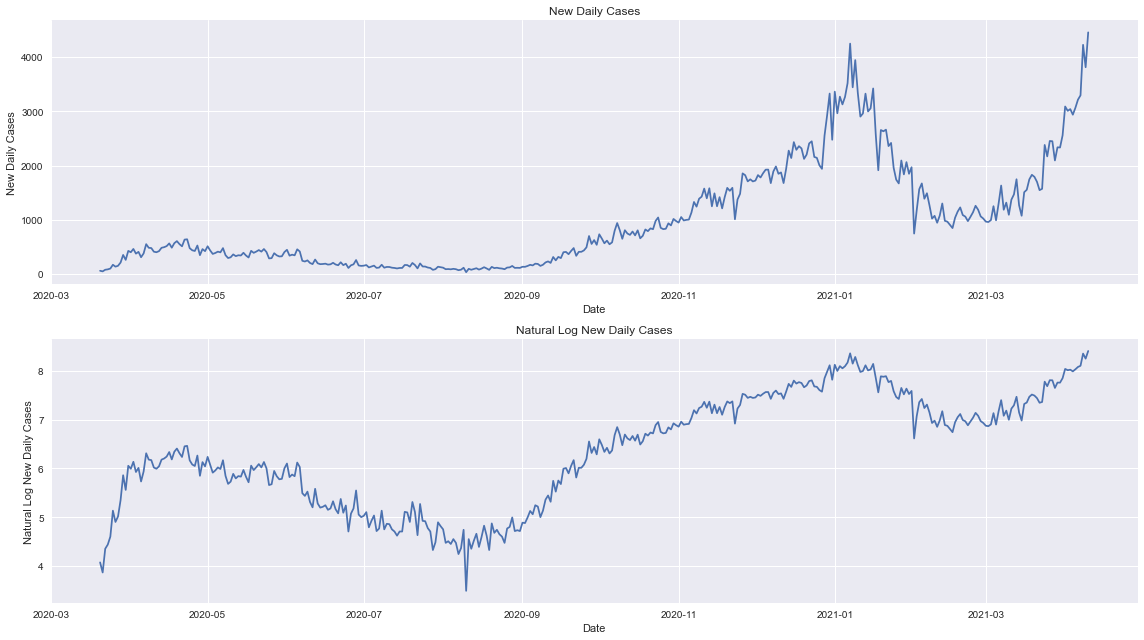

In [40]:
# visualize cases vs ln cases
fig, ax = plt.subplots(2, figsize=(16,9))
ax[0].set_title('New Daily Cases')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('New Daily Cases')
ax[0].plot(df_cases['new_cases'], label='New Daily Cases')

ax[1].set_title('Natural Log New Daily Cases')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Natural Log New Daily Cases')
ax[1].plot(df_cases['ln_cases'], label='Natural Log Cases')

plt.tight_layout()

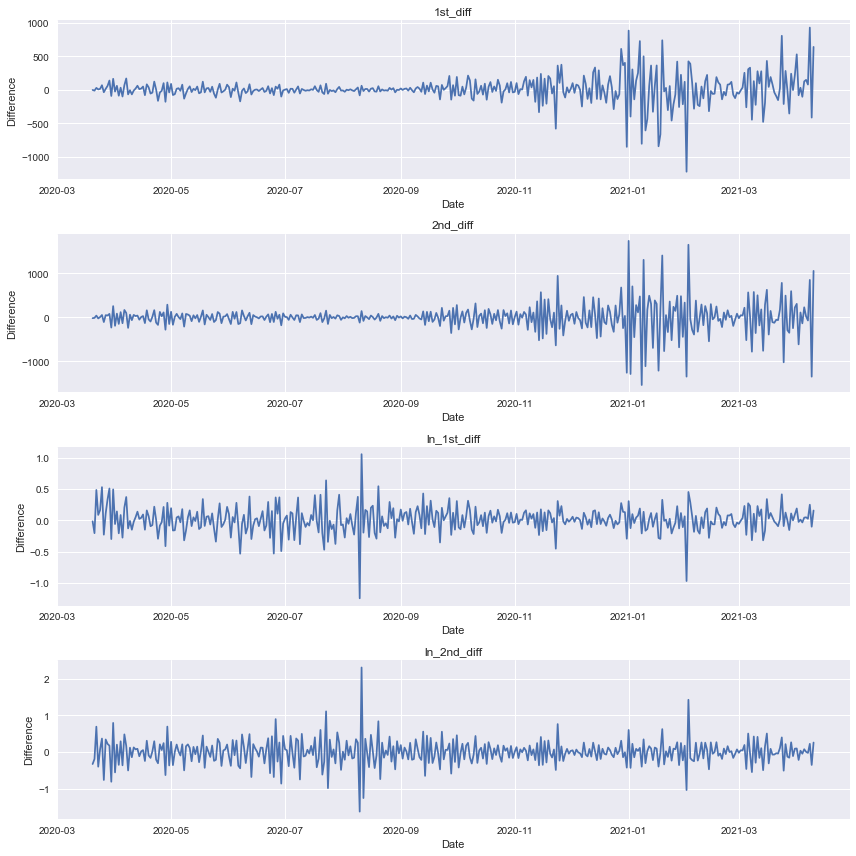

In [42]:
# check diffencing for stationarity
fig, ax = plt.subplots(4, figsize=(12,12))
for count, i in enumerate(['1st_diff', '2nd_diff', 'ln_1st_diff', 'ln_2nd_diff']):
    ax[count].set_title(i)
    ax[count].set_xlabel('Date')
    ax[count].set_ylabel('Difference')
    ax[count].plot(df_cases[i].index, df_cases[i])
plt.tight_layout()

# ln transform differencing (1st and 2nd) appears more stationary

In [45]:
# use augmented Dickey-Fuller test for more obhective check for stationarity
dict_pval = {'{}_p_value'.format(col): adfuller(df_cases[col])[1]
             for col in ['1st_diff', '2nd_diff', 'ln_1st_diff', 'ln_2nd_diff']}

# inspect p-values
dict_pval

{'1st_diff_p_value': 0.35984355447014194,
 '2nd_diff_p_value': 6.505877760525546e-11,
 'ln_1st_diff_p_value': 0.004260532121195854,
 'ln_2nd_diff_p_value': 1.1578254064717327e-16}

In [47]:
# use 2nd difference of ln transformed values for model, since it has the lowest p-value
# must still find p (AR) and q (MA) for ARIMA model (will use I = 2, since using 2nd difference)
# ACF and PACF plots don't give a clear picture as how to set p and q for ARMA model
# use aic and bic values of each trial model, and store in list_vals
list_vals = []

# loop over AR models
for p in range(4):
    
    # loop over MA models
    for q in range(4):
        
        try:
            
            # fit model
            model = SARIMAX(df_cases['ln_cases'], order=(p,2,q), trend='c')
            results = model.fit()

            # append test values to list
            list_vals.append((p, q, results.aic, results.bic))
            
        except:
            
            # if error found, print None for AIC and/or BIC
            list_vals.append((p, q, None, None))
            

# create dataframe and sort by AIC for favourable predictive model
df_pq = pd.DataFrame(list_vals, columns=['p', 'q', 'AIC', 'BIC'])
df_pq.sort_values('AIC').head()

/Users/erwinremigio/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/erwinremigio/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/erwinremigio/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/erwinremigio/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-

,p,q,AIC,BIC
6,1,2,-181.669715,-161.903499
3,0,3,-181.403430,-161.637214
10,2,2,-179.892300,-156.172840
2,0,2,-179.151478,-163.338504
11,2,3,-178.637279,-150.964576


In [53]:
# p = 1, q = 2
mod = SARIMAX(df_cases['ln_cases'], order=(1,2,2), trend='c')
res = mod.fit()

# check one step ahead predictions (historic accuracy check, previous 28 days)
fc = res.get_prediction(start=-28)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

# forward predctions (28 days)
fwd = res.get_forecast(steps=28)
fwd_m = fwd.predicted_mean
fwd_ci = fwd.conf_int()

In [58]:
# check start of backtest period
fc_mean.head()

# first day 2021-03-14

date
2021-03-14    7.368471
2021-03-15    7.266908
2021-03-16    7.153587
2021-03-17    7.264888
2021-03-18    7.309220
Freq: D, Name: predicted_mean, dtype: float64

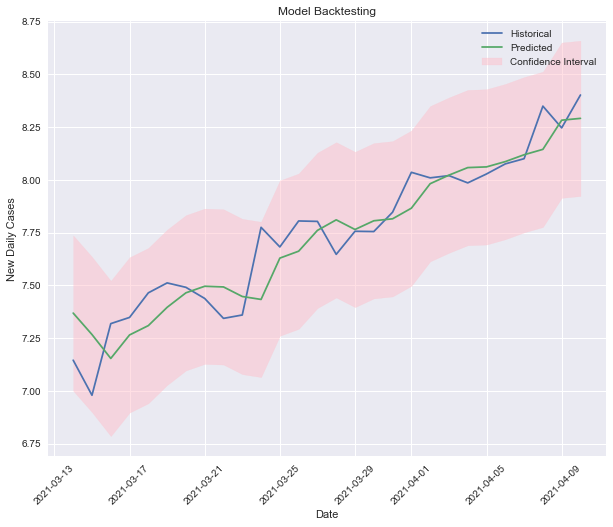

In [59]:
# visualize accuracy of backtesting

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(df_cases.loc['2021-03-14':, 'ln_cases'].index, df_cases.loc['2021-03-14':, 'ln_cases'], label='Historical')
ax.plot(fc_mean.index, fc_mean, label='Predicted')
ax.fill_between(fc_mean.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color='pink', alpha=0.5, label='Confidence Interval')
ax.set_title('Model Backtesting')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('New Daily Cases')
ax.legend()

plt.show()

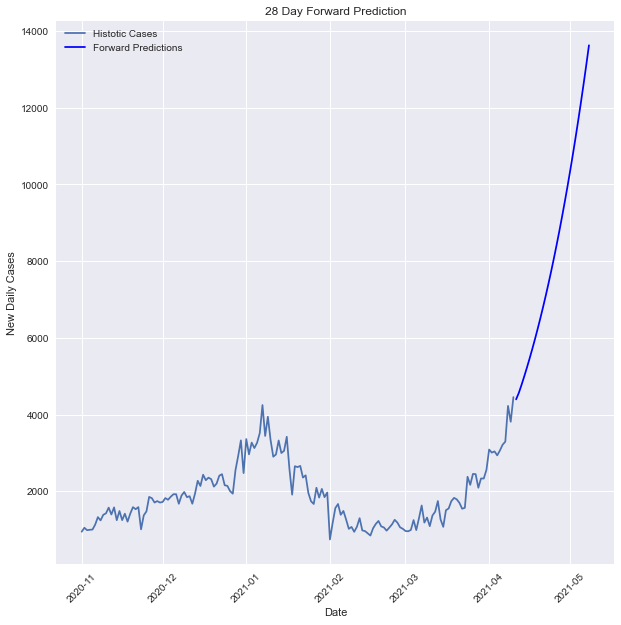

In [64]:
# must transform predicted ln cases to raw cases
# compare to second wave for better comparison and graph scale (start at 2020-11-01)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Date')
ax.set_ylabel('New Daily Cases')
ax.set_title('28 Day Forward Prediction')
ax.plot(df_cases.loc['2020-11-01':, 'new_cases'], label='Histotic Cases')
ax.plot(fwd_m.index, np.exp(fwd_m), color='blue', label='Forward Predictions') # use np.exp() to revert back to raw cases
ax.tick_params(axis='x', labelrotation=45)
ax.legend(loc=2)

plt.show()

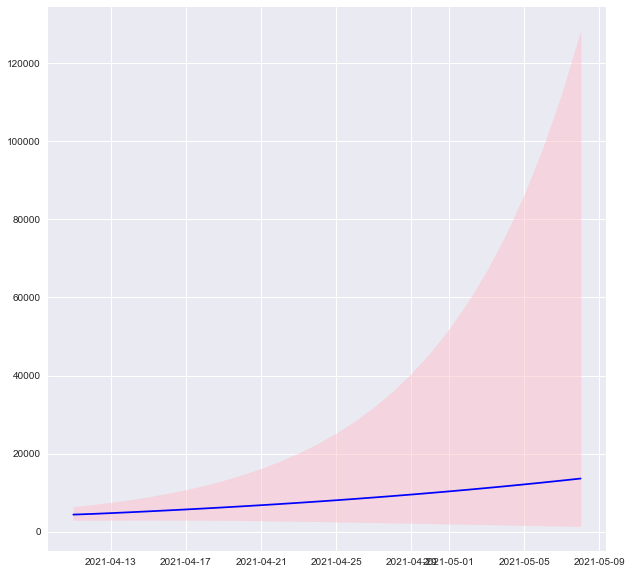

In [66]:
# confidence interval is greatly exagerated because data was ARIMA model was subjected to ln transform
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(fwd_m.index, np.exp(fwd_m), color='blue', label='Forward Predictions') # use np.exp() to revert back to raw cases
ax.fill_between(fwd_ci.index, np.exp(fwd_ci.iloc[:,0]), np.exp(fwd_ci.iloc[:,1]), color='pink', alpha=0.5, label='Confidence Interval')

plt.show()

In [74]:
# tabular view of 28 day prediction of cases
np.exp(fwd_m)

2021-04-11     4397.002516
2021-04-12     4564.970795
2021-04-13     4772.484677
2021-04-14     4993.151080
2021-04-15     5223.303339
2021-04-16     5462.630164
2021-04-17     5711.322005
2021-04-18     5969.647640
2021-04-19     6237.891214
2021-04-20     6516.342782
2021-04-21     6805.296778
2021-04-22     7105.051656
2021-04-23     7415.909689
2021-04-24     7738.176784
2021-04-25     8072.162285
2021-04-26     8418.178765
2021-04-27     8776.541807
2021-04-28     9147.569760
2021-04-29     9531.583496
2021-04-30     9928.906145
2021-05-01    10339.862812
2021-05-02    10764.780286
2021-05-03    11203.986734
2021-05-04    11657.811374
2021-05-05    12126.584142
2021-05-06    12610.635335
2021-05-07    13110.295252
2021-05-08    13625.893802
Freq: D, Name: predicted_mean, dtype: float64